In [3]:
from analysis_classes import *
import os

dataset_directory = "../csv_to_protobuf_bin/binary_logs/DTNS/"

dtns_data_tmp = os.listdir(dataset_directory)

labels_ = "89"
dtns_data = []

for i in dtns_data_tmp:
    # if labels_ in i:
    #     dtns_data.append(i)
    dtns_data.append(i)

print("Data in directory {} is\t{}".format(dataset_directory, len(dtns_data)))


dtns_df = TransferAnalysis(dataset_directory+dtns_data[0]).df
print("Dataframe shape for dtns dataset: {}".format(dtns_df.shape))

Data in directory ../csv_to_protobuf_bin/binary_logs/DTNS/ is	1
Dataframe shape for dtns dataset: (9, 95)


In [4]:
def train_test_split_df(df):
    df = df.sample(frac=1).reset_index(drop=True)
    x = df.drop(df.columns[len(df.columns)-1],axis=1)
    y = df[df.columns[len(df.columns)-1]]
    # total_labels = len(dict(Counter(y)))

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    return x_train, x_test, y_train, y_test

# a, b, c, d = train_test_split_df(dtns_df)

In [5]:
# Running a model with a data set default model is random forest
a = Model_Run()
x_dtns_train, x_dtns_test, y_dtns_train, y_dtns_test = train_test_split_df(dtns_df)
print("Accuracy of the model {} is".format(a.model_to_name[a.model_name]), a.run_model(dtns_df))

Accuracy of the model Random Forest is 1.0


In [6]:
# Creating a model (classifier) with train dataset
# self.model_to_name = {"RF": "Random Forest", "DT": "Decision Tree", "MLP": "MLP Classifier",
#                       "KN": "KNeighborsClassifier", "QDA": "QuadraticDiscriminantAnalysis", "NB": "GaussianNB",
#                       "ADA": "AdaBoostClassifier", "svm": "SVM", "sdg": "SGDClassifier"}
data_set_1_classifier = a.generate_with_all(x_dtns_train, y_dtns_train, model_name="RF")
data_set_2_classifier = a.generate_with_all(x_dtns_train, y_dtns_train)

#Comparing the accuracy of model on different dataset
a.compare_two_dataset(dtns_df, dtns_df, model_name="RF")


	Accuracy: 1.0


	Accuracy: 1.0


In [7]:
dtns_df.describe()

,avg_rtt_value,pacing_rate,cwnd_rate,avg_retransmission_timeout_value,byte_ack,seg_out,retrans,mss_value,ssthresh_value,segs_in,...,exit_code,cpu_usage_percentage,mem_usage_percentage,tcp_rcv_buffer_min,tcp_rcv_buffer_default,tcp_rcv_buffer_max,tcp_snd_buffer_min,tcp_snd_buffer_default,tcp_snd_buffer_max,label_value
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,9.0,9.000000,9.000000,9.0,...,9.0,9.000000,9.000000,9.0,9.0,9.0,9.0,9.0,9.0,9.0
mean,0.065861,694.200012,7.092761,34.450553,-0.049721,-33.0,0.0,244.531377,10822.877496,-4.0,...,0.0,108.888889,0.533333,4096.0,131072.0,6291456.0,4096.0,16384.0,4194304.0,0.0
std,0.031249,0.000000,3.365328,16.345880,0.000000,0.0,0.0,116.023692,5135.170166,0.0,...,0.0,46.468926,0.165831,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.035455,694.200012,3.818182,18.545454,-0.049721,-33.0,0.0,131.636368,5826.181641,-4.0,...,0.0,38.000000,0.300000,4096.0,131072.0,6291456.0,4096.0,16384.0,4194304.0,0.0
25%,0.043333,694.200012,4.666667,22.666666,-0.049721,-33.0,0.0,160.888885,7120.888672,-4.0,...,0.0,89.000000,0.400000,4096.0,131072.0,6291456.0,4096.0,16384.0,4194304.0,0.0
50%,0.055714,694.200012,6.000000,29.142857,-0.049721,-33.0,0.0,206.857147,9155.428711,-4.0,...,0.0,109.000000,0.600000,4096.0,131072.0,6291456.0,4096.0,16384.0,4194304.0,0.0
75%,0.078000,694.200012,8.400000,40.799999,-0.049721,-33.0,0.0,289.600006,12817.599609,-4.0,...,0.0,123.000000,0.700000,4096.0,131072.0,6291456.0,4096.0,16384.0,4194304.0,0.0
max,0.130000,694.200012,14.000000,68.000000,-0.049721,-33.0,0.0,482.666656,21362.666016,-4.0,...,0.0,191.000000,0.700000,4096.0,131072.0,6291456.0,4096.0,16384.0,4194304.0,0.0


Text(0.5, 1.0, 'Correlation Matrix Heatmap')

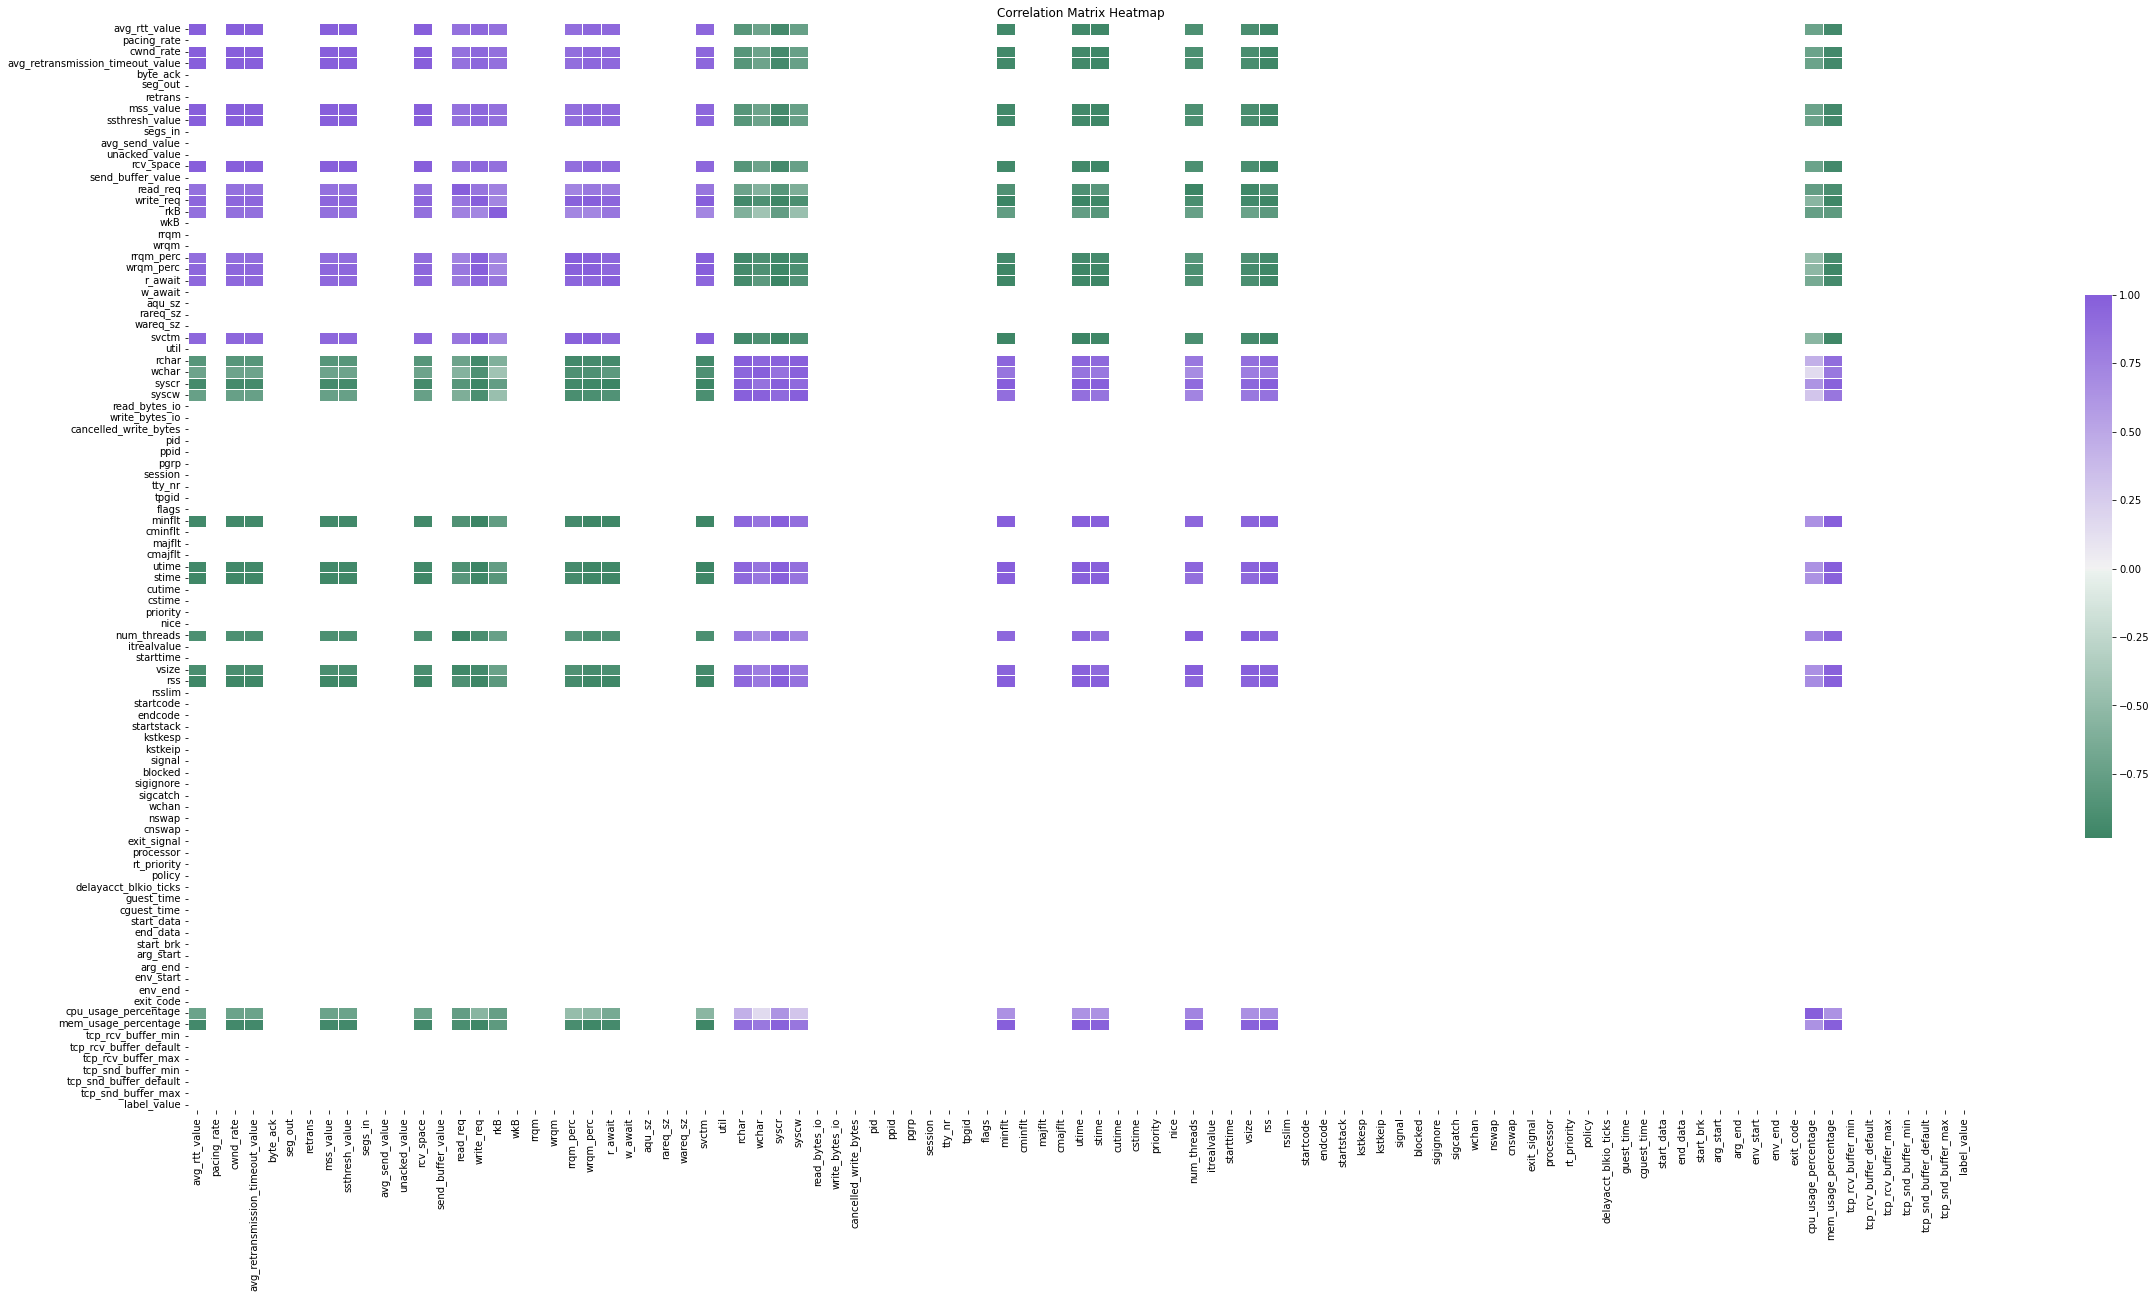

In [8]:
# Get the correlation of the data
correlation = dtns_df.corr()
f, axes = plt.subplots(figsize=(40,20))
#diverging color map generate
cmap = sns.diverging_palette(150, 275, as_cmap = True)

sns.heatmap(correlation, cmap= cmap, center = 0, linewidth = 1, cbar_kws={"shrink": 0.5})

plt.title('Correlation Matrix Heatmap')

In [9]:
#Get the columns name in the dataset
dtns_df.columns

Index(['avg_rtt_value', 'pacing_rate', 'cwnd_rate',
       'avg_retransmission_timeout_value', 'byte_ack', 'seg_out', 'retrans',
       'mss_value', 'ssthresh_value', 'segs_in', 'avg_send_value',
       'unacked_value', 'rcv_space', 'send_buffer_value', 'read_req',
       'write_req', 'rkB', 'wkB', 'rrqm', 'wrqm', 'rrqm_perc', 'wrqm_perc',
       'r_await', 'w_await', 'aqu_sz', 'rareq_sz', 'wareq_sz', 'svctm', 'util',
       'rchar', 'wchar', 'syscr', 'syscw', 'read_bytes_io', 'write_bytes_io',
       'cancelled_write_bytes', 'pid', 'ppid', 'pgrp', 'session', 'tty_nr',
       'tpgid', 'flags', 'minflt', 'cminflt', 'majflt', 'cmajflt', 'utime',
       'stime', 'cutime', 'cstime', 'priority', 'nice', 'num_threads',
       'itrealvalue', 'starttime', 'vsize', 'rss', 'rsslim', 'startcode',
       'endcode', 'startstack', 'kstkesp', 'kstkeip', 'signal', 'blocked',
       'sigignore', 'sigcatch', 'wchan', 'nswap', 'cnswap', 'exit_signal',
       'processor', 'rt_priority', 'policy', 'delayac